In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [8]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [9]:
length = [len(i) for i in tokenized]

(array([3.060e+02, 1.992e+03, 8.900e+02, 3.930e+02, 1.490e+02, 8.000e+01,
        2.500e+01, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 2. ,  5.3,  8.6, 11.9, 15.2, 18.5, 21.8, 25.1, 28.4, 31.7, 35. ]),
 <BarContainer object of 10 artists>)

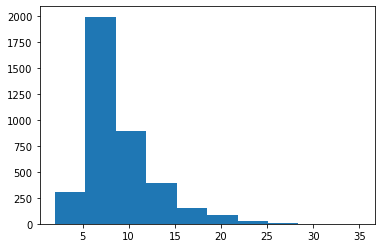

In [10]:
plt.hist([len(i) for i in tokenized])

In [11]:
max(tokenized, key=lambda x: len(x))

['a',
 'woman',
 'laughs',
 'as',
 'she',
 'takes',
 'part',
 'in',
 'some',
 'traditional',
 'or',
 'national',
 'custom',
 'and',
 'a',
 'man',
 'behind',
 'her',
 'screams',
 'with',
 'joy',
 'to',
 'amuse',
 'her',
 'even',
 'more',
 'while',
 'people',
 'on',
 'the',
 'background',
 'are',
 'dining',
 'and',
 'smiling']

In [12]:
np.mean(length), np.median(length), np.max(length), np.min(length)

(8.873177083333333, 8.0, 35, 2)

In [13]:
unique_length, counts = np.unique(length, return_counts=True)
list(zip(unique_length, counts))

[(2, 1),
 (3, 19),
 (4, 68),
 (5, 218),
 (6, 526),
 (7, 862),
 (8, 604),
 (9, 437),
 (10, 278),
 (11, 175),
 (12, 143),
 (13, 105),
 (14, 83),
 (15, 62),
 (16, 61),
 (17, 50),
 (18, 38),
 (19, 34),
 (20, 27),
 (21, 19),
 (22, 9),
 (23, 7),
 (24, 5),
 (25, 4),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (35, 1)]

In [14]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [15]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [16]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [17]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [18]:
len(unique_tokens)

2162

In [19]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [20]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [21]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [22]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, tokenized, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [23]:
def sort(images, text):
    length = [len(i) for i in text]
    images, text, _ = zip(*sorted(zip(images, text, length), key = lambda x: x[-1]))
    return images, text

In [24]:
def prepare(images, text, vocab, pad_token, start_token, end_token, batch_size=64):
    images, text = sort(images, text)
    images = np.array(np.array_split(images, len(images)//batch_size))
    text = np.array(np.array_split(text, len(text)//batch_size))
    prepared_text = []
    length = []
    for batched_text in text:
        maxlen = max([len(i) for i in batched_text])
        batch_padded = np.array(list(map(lambda x: [vocab[i] for i in x],padd(batched_text, pad_token, start_token, end_token, maxlen))))
        length.append((batch_padded!=vocab[pad_token]).sum(axis=1)-2)
        prepared_text.append(batch_padded)
    return images, prepared_text, np.array(length)

In [25]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [26]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [27]:
len(class_weights), len(vocab)

(2165, 2165)

In [28]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [29]:
class_weights = np.array(class_weights)

In [30]:
class_weights.shape

(2165,)

# Model with transfer learning

In [31]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [32]:
import tensorflow.keras.applications as apps


In [33]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        self.resnet_extractor = apps.ResNet152V2(include_top=False, weights='imagenet')
        self.resnet_extractor.trainable = False
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(units=256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=256, activation='relu')
    def call(self, input):
        extracted = self.pooling(self.resnet_extractor(input))
        return [self.dense1(extracted), self.dense2(extracted)]

In [34]:
conv_encoder = ConvEncoder()

In [35]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



### LSTM model

### making w2v embeddings

In [36]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [37]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [38]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [39]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [40]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### building model

In [41]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [42]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

### Training

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = True

In [44]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [45]:
train_images, train_sequences, train_length = prepare(train_images, train_sequences, vocab, pad_token, start_token, end_token, batch_size=batch_size)

In [46]:
val_images, val_sequences, val_length = prepare(val_images, val_sequences, vocab, pad_token, start_token, end_token, batch_size=batch_size)

In [47]:
test_images, test_sequences, test_length = prepare(test_images, test_sequences, vocab, pad_token, start_token, end_token, batch_size=batch_size)

In [48]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [49]:
train_images.shape, train_sequences[0].shape, train_length.shape 

((48, 64, 224, 224, 3), (64, 6), (48, 64))

In [50]:
val_images.shape, val_sequences[1].shape, val_length.shape 

((6, 64, 224, 224, 3), (64, 9), (6, 64))

In [51]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [52]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [53]:
from tqdm import tqdm

In [54]:
tf.keras.backend.set_floatx('float64')

In [55]:
def generator(images, text, length):
    while True:
        for batched_image, batched_text, batched_length in zip(images, text, length):
            yield batched_image, batched_text, batched_length

In [56]:
train_generator = generator(train_images, train_sequences, train_length)

In [57]:
val_generator = generator(val_images, val_sequences, val_length)

In [58]:
train_images.shape[0]

48

In [59]:
@tf.function
def train_step():
    image, target,lengths =  next(train_generator)
    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [60]:
@tf.function
def evaluate():
    image, target, lengths = next(val_generator)
    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [61]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for i in tqdm(range(train_images.shape[0])):
        batched_train_loss, batched_train_perplexity = train_step()
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for i in range(val_images.shape[0]):
        batched_val_loss, batched_val_perplexity = evaluate()
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


Finished epoch 0; Train loss : 3.54453182220459; Train perplexity : 127.35286712646484


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.7834954261779785; Validation perplexity : 119.52140045166016


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 1; Train loss : 1.1896458864212036; Train perplexity : 3.4609873294830322


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.7660346031188965; Validation perplexity : 117.45257568359375


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 2; Train loss : 0.5002059936523438; Train perplexity : 1.6600269079208374


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.838261127471924; Validation perplexity : 126.24968719482422


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 3; Train loss : 0.23594097793102264; Train perplexity : 1.2675715684890747


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.878942966461182; Validation perplexity : 131.49159240722656
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 4; Train loss : 0.1492607295513153; Train perplexity : 1.160988211631775


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.924103260040283; Validation perplexity : 137.5659942626953


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 5; Train loss : 0.13241447508335114; Train perplexity : 1.1415945291519165


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.914368152618408; Validation perplexity : 136.2332763671875


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 6; Train loss : 0.11704687029123306; Train perplexity : 1.1241817474365234


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.904858112335205; Validation perplexity : 134.94383239746094


100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Finished epoch 7; Train loss : 0.10382136702537537; Train perplexity : 1.109409213066101


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.896690845489502; Validation perplexity : 133.84613037109375


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 8; Train loss : 0.09229433536529541; Train perplexity : 1.0966929197311401


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.891456604003906; Validation perplexity : 133.14735412597656


100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Finished epoch 9; Train loss : 0.08216948807239532; Train perplexity : 1.0856438875198364


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.887143611907959; Validation perplexity : 132.57437133789062


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 10; Train loss : 0.0732288584113121; Train perplexity : 1.0759798288345337


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.883774280548096; Validation perplexity : 132.12841796875


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 11; Train loss : 0.0653129443526268; Train perplexity : 1.0674954652786255


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.881460189819336; Validation perplexity : 131.82301330566406


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 12; Train loss : 0.058287739753723145; Train perplexity : 1.0600216388702393


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.881319522857666; Validation perplexity : 131.80445861816406


100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Finished epoch 13; Train loss : 0.052042294293642044; Train perplexity : 1.0534218549728394


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.883163928985596; Validation perplexity : 132.0478515625


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 14; Train loss : 0.04648180678486824; Train perplexity : 1.047580361366272


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.885643005371094; Validation perplexity : 132.37554931640625
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 15; Train loss : 0.04355728253722191; Train perplexity : 1.0445197820663452


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.875307559967041; Validation perplexity : 131.01441955566406


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 16; Train loss : 0.04296751692891121; Train perplexity : 1.0439039468765259


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.874919414520264; Validation perplexity : 130.963623046875


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 17; Train loss : 0.04237524792551994; Train perplexity : 1.0432859659194946


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.874673366546631; Validation perplexity : 130.93138122558594


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Finished epoch 18; Train loss : 0.041793327778577805; Train perplexity : 1.042678952217102


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.874397277832031; Validation perplexity : 130.89524841308594


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 19; Train loss : 0.04122098162770271; Train perplexity : 1.04208242893219


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.874208927154541; Validation perplexity : 130.87059020996094


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 20; Train loss : 0.04065745696425438; Train perplexity : 1.0414952039718628


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873997211456299; Validation perplexity : 130.84288024902344


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 21; Train loss : 0.04010247811675072; Train perplexity : 1.0409175157546997


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873852252960205; Validation perplexity : 130.823974609375


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 22; Train loss : 0.03955565765500069; Train perplexity : 1.0403484106063843


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873697757720947; Validation perplexity : 130.8037109375


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 23; Train loss : 0.03901693969964981; Train perplexity : 1.0397878885269165


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873549938201904; Validation perplexity : 130.7843017578125


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 24; Train loss : 0.03848611190915108; Train perplexity : 1.039236068725586


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873477458953857; Validation perplexity : 130.77490234375


100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Finished epoch 25; Train loss : 0.037962764501571655; Train perplexity : 1.038692593574524


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873394012451172; Validation perplexity : 130.76397705078125


100%|██████████| 48/48 [00:45<00:00,  1.04it/s]


Finished epoch 26; Train loss : 0.03744679316878319; Train perplexity : 1.0381566286087036


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873402118682861; Validation perplexity : 130.76512145996094


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Finished epoch 27; Train loss : 0.036938149482011795; Train perplexity : 1.0376287698745728


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873401641845703; Validation perplexity : 130.76499938964844


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 28; Train loss : 0.03643663600087166; Train perplexity : 1.0371085405349731


  0%|          | 0/48 [00:00<?, ?it/s]

Validation loss : 4.873363494873047; Validation perplexity : 130.75999450683594


100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


Finished epoch 29; Train loss : 0.03594202175736427; Train perplexity : 1.0365957021713257
Validation loss : 4.873375415802002; Validation perplexity : 130.7615509033203


# Viewing and saving results

In [66]:
df = pd.DataFrame()
model_name = 'conv_lstm_enc_dec_logits_transfer_w2v_resnet_learning_dynamic_length_weights'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

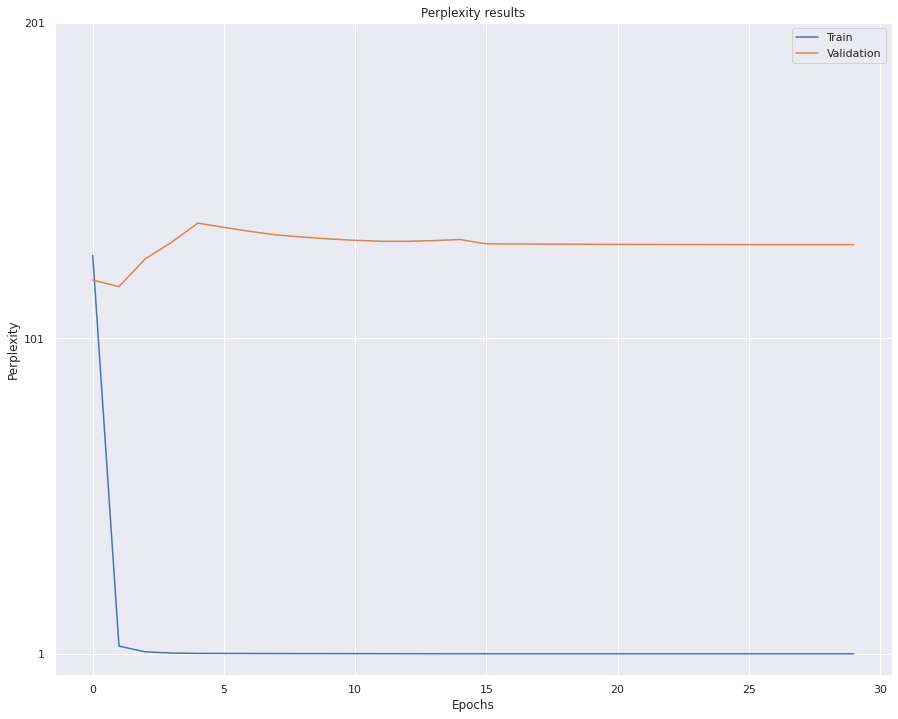

In [68]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

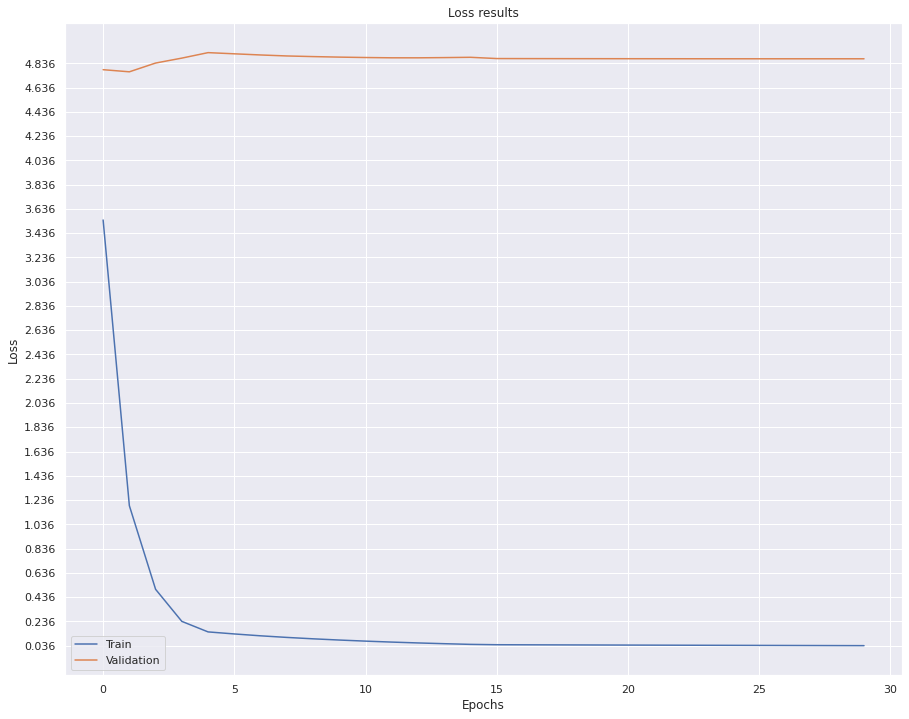

In [69]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['val_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [72]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state = self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [73]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [74]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [75]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [76]:
images.shape

(3840, 224, 224, 3)

In [77]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the couple is happy to be in focus during the event


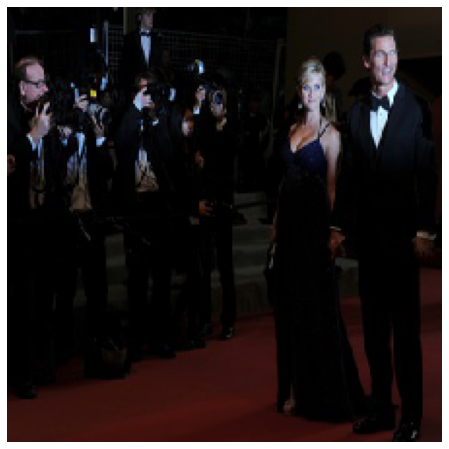

In [78]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [79]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'men are sad'

In [80]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'serious men are discussing something'

# Blue score calculation

In [81]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [82]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [03:53<00:00, 38.90s/it]


In [83]:
test_predictions = [i.split(' ') for i in test_predictions]

In [84]:
test_sequences[0].shape

(64, 8)

In [85]:
test_sentences = []
for z in test_sequences:
    for i in z:
        tmp = []
        for word in i:
            if word!=0 and word!=1 and word!=2:
                tmp.append(inverse_vocab[word])
        test_sentences.append(tmp)

In [86]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 2.905614758594547e-80


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [87]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.04492213234490663


In [88]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.011743584828493638


In [89]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.0015699887764213947


In [90]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 2.6940538984659e-309


In [91]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 2.905614758594547e-80


In [92]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,127.352867,119.521400,3.544532,4.783495,2.905615e-78,4.492213,1.174358,0.156999,2.694054e-307,2.905615e-78
1,3.460987,117.452576,1.189646,4.766035,2.905615e-78,4.492213,1.174358,0.156999,2.694054e-307,2.905615e-78
2,1.660027,126.249687,0.500206,4.838261,2.905615e-78,4.492213,1.174358,0.156999,2.694054e-307,2.905615e-78
3,1.267572,131.491592,0.235941,4.878943,2.905615e-78,4.492213,1.174358,0.156999,2.694054e-307,2.905615e-78
4,1.160988,137.565994,0.149261,4.924103,2.905615e-78,4.492213,1.174358,0.156999,2.694054e-307,2.905615e-78


In [93]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [94]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [95]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [96]:
img = np.array(im.load_img('download.jpeg', target_size=(224,224)))/255

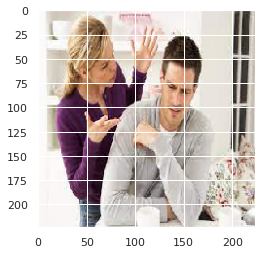

In [97]:
plt.imshow(img)

In [98]:
predict(img, greedy_decoder, inverse_vocab)

'two men look cautious'

In [99]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'two men researching something'